# Device Survival Analysis
### Maintenance cost reduction through predictive techniques


BACKGROUND: A company has a fleet of devices transmitting daily telemetry readings. They
would like to create a predictive maintenance solution to proactively identify when maintenance
should be performed. This approach promises cost savings over routine or time-based
preventive maintenance, because tasks are performed only when warranted. GOAL You are
tasked with building a predictive model using machine learning to predict the probability of a
device failure. When building this model, be sure to minimize false positives and false
negatives. The column you are trying to predict is called failure with binary value 0 for non-
failure and 1 for failure.

## Outline 
#### Part 1. Exploratory Analysis and Feature Engineering
- Basic descriptives  
- Data cleaning
- Censoring
- Feature engineering by device ID

#### Part 2. Modeling
- A. Cox regression analysis
- B. Multi-Task Logistic Regression (MTLR)
- C. Feed-Forward Neural Network
    - Data prep & Train-test split
    - Model training
    - Model evaluation
    - Predicting on new data (Hazard function, Risk function)
- D. DeepSurv Neural Cox
    - Data prep & Train-test split
    - Model training
    - Model evaluation
    - Predicting on new data (Hazard function, Risk function)

#### Part 3: Conclusion: comparison of models

Trained on ml.p2.xlarge AWS SageMaker instance

In [1]:
! pip install pysurvival
! pip install scikit-survival

     |████████████████████████████████| 4.7 MB 23.8 MB/s eta 0:00:01
     |████████████████████████████████| 831.4 MB 5.6 kB/s  eta 0:00:01     |█████████████▊                  | 357.0 MB 59.3 MB/s eta 0:00:08     |█████████████████▍              | 452.3 MB 42.1 MB/s eta 0:00:10
  Created wheel for pysurvival: filename=pysurvival-0.1.2-cp36-cp36m-linux_x86_64.whl size=3736723 sha256=444eb46b9a0364d92e1df49ffb68df1f115ff8f82ca5ea265f855aafae289e3d
  Stored in directory: /home/ec2-user/.cache/pip/wheels/83/3b/71/445830e052bd5a4204ca2b3f218913eb5de506e4fb22bf17ec
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12075 sha256=94c7122e699b23f11253f6356059d6d4ca24b72df517c07c71807e96a8e9c033
  Stored in directory: /home/ec2-user/.cache/pip/wheels/bc/13/93/a9bf6b3d3966e4af014b0dbef027fdea47393faf47e990349f
Successfully built pysurvival progressbar
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip'

  Created wheel for scs: filename=scs-2.1.4-cp36-cp36m-linux_x86_64.whl size=351400 sha256=dd5f16e99d8f44c0bcf5e3404715b6dbda494bd094e3eac91088c8261f728fb6
  Stored in directory: /home/ec2-user/.cache/pip/wheels/ab/2d/00/a58b6277713e48ca51644a8e07d2e0d18fecc8e9093e660181
Successfully built scikit-survival cvxpy scs
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_censored
from sksurv.linear_model import CoxPHSurvivalAnalysis
from pysurvival.utils.display import display_loss_values

# Part 1. Exploratory Analysis and Feature Engineering

### Basic descriptives

In [14]:
df=pd.read_csv('http://aws-proserve-data-science.s3.amazonaws.com/predictive_maintenance.csv')
print(df.shape)

(124494, 12)


In [15]:
# first few rows
df.head(2).T

,0,1
date,1/1/15,1/1/15
device,S1F01085,S1F0166B
failure,0,0
metric1,215630672,61370680
metric2,56,0
metric3,0,3
metric4,52,0
metric5,6,6
metric6,407438,403174
metric7,0,0


In [16]:
# except for the first two columns, all metrics are integers.
df.dtypes

date       object
device     object
failure     int64
metric1     int64
metric2     int64
metric3     int64
metric4     int64
metric5     int64
metric6     int64
metric7     int64
metric8     int64
metric9     int64
dtype: object

### Hypotheses about the data:

* one reading every day, per device
* no more than one reading per day, per device
* most devices start on the same day (Jan 1st)
* there are no devices with two failure records (each device can only fail once)
* once a failure happens, device is removed from service
* some models never fail during the observation period (censoring)

### Data cleaning

In [17]:
# There is no obvious missing data in any variable.
df.isnull().sum()

date       0
device     0
failure    0
metric1    0
metric2    0
metric3    0
metric4    0
metric5    0
metric6    0
metric7    0
metric8    0
metric9    0
dtype: int64

In [18]:
# metrics 7 and 8 are identical. Drop one of them.
print('correlation:', df['metric7'].corr(df['metric8']))
print ('Are there any rows where 7!=8?', False in list(df['metric7']==df['metric8']))
df=df.drop('metric8', axis=1)
print(df.shape)

correlation: 1.0
Are there any rows where 7!=8? False
(124494, 11)


In [19]:
# There is only one instance of a duplicated device-date pair.
print('How many devices have 2 measurements in one day?', df[['device', 'date']].duplicated().sum())
# what is that row?
print(df[df[['device', 'date']].duplicated()==True][['device', 'date']])
df.loc[(df['device']=='S1F0R4Q8') & (df['date']=='2015-07-10')]

How many devices have 2 measurements in one day? 1
          device     date
101335  S1F0R4Q8  7/10/15


,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9


In [20]:
# we should remove one of these duplicate rows.
df=df.drop(df.index[101335], axis=0)
df.reset_index(drop=True)
df.shape

(124493, 11)

In [21]:
# The dates are coded as strings. Replace this.
print(df['date'].dtype)
df['date']=pd.to_datetime(df['date'],infer_datetime_format=True)
df['date'].dtype

object


dtype('<M8[ns]')

In [22]:
# metric 1 appears to be an entirely random signal. remove it.
df['metric1'].describe()
df=df.drop('metric1', axis=1)

In [23]:
# what percentage of each is a zero? very high.
def lotsa_zeroes(col):
    numerator=len(df.loc[df[col]==0])
    denominator=len(df[col])
    print(col+':', round(numerator/denominator, 2))
for i in [2, 3,4,7]:
    lotsa_zeroes('metric'+str(i))

metric2: 0.95
metric3: 0.93
metric4: 0.92
metric7: 0.99


### Censoring
What is censoring? One of the challenges specific to survival analysis is that only some individuals will have experienced the event by the end of the study, and therefore survival times will be unknown for a subset of the study group. This phenomenon is called censoring. [Source](https://scikit-survival.readthedocs.io/en/stable/user_guide/understanding_predictions.html)

![](https://scikit-survival.readthedocs.io/en/stable/_images/censoring.svg)

In [24]:
# How many unique observations are there for date, device, and overall?
print(df['date'].nunique())
print(df['device'].nunique())
print(len(df))

304
1169
124493


In [25]:
# Do all of devices experience failure? Most do not (but this may be due to censoring).
df.groupby('device').max()['failure'].value_counts()

0    1063
1     106
Name: failure, dtype: int64

In [26]:
# Do any fail multiple times? No. Each device failes only once.
df.groupby('device').sum()['failure'].value_counts()

0    1063
1     106
Name: failure, dtype: int64

For the most part, when a device fails it is removed. A few devices (5) continue after they're dead.

In [27]:
# confirm that there are no devices with two failure records (each device only fails once)
dffailed=df.loc[df['failure']==1]
assert dffailed['device'].nunique()==dffailed.shape[0]

In [28]:
# restrict to the date on which a device failed.
deaddevice=df[df['failure']==1][['device','date']]

In [29]:
# merge the deathdates back into the regular dataset.
deaddevice = deaddevice.rename(columns={'date': 'deathdate'})
df=pd.merge(df, deaddevice, on='device', how='outer')
df.shape

(124493, 11)

In [30]:
# confirm that, for failed devices, there are no entries later than the failure date.
devices=df.groupby('device').max().reset_index(drop=False)
dead_devices=devices.loc[devices['failure']==1]
dead_devices=dead_devices.rename(columns={'date': 'maxdate'})
dead_devices=dead_devices[['device', 'maxdate', 'deathdate']]
dead_devices.loc[dead_devices['maxdate']!=dead_devices['deathdate']]

,device,maxdate,deathdate
101,S1F0GPFZ,2015-07-24,2015-07-12
504,S1F136J0,2015-05-06,2015-05-05
599,W1F0KCP2,2015-05-11,2015-05-09
625,W1F0M35B,2015-05-11,2015-05-09
819,W1F11ZG9,2015-08-17,2015-07-18


In [31]:
# For those 5 devices, remove any dates that occur after the failure.
zombies=dead_devices.loc[dead_devices['maxdate']!=dead_devices['deathdate']]['device']
print('Number of rows removed:', df.loc[(df['device'].isin(zombies)) & (df['date']>df['deathdate'])].shape[0])
print(df.shape[0])
df=df.loc[~((df['device'].isin(zombies)) & (df['date']>df['deathdate']))]
print(df.shape[0])
df=df.drop(['deathdate'], axis=1)

Number of rows removed: 47
124493
124446


## Feature engineering by device ID

In [32]:
# What's the first date in the series?
print(df['date'].min())
# Do all devices start on this same date? No.
bydevice=df.groupby('device')['date', 'failure'].min().reset_index(drop=False)
bydevice['date'].value_counts()

2015-01-01 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


2015-01-01    1163
2015-05-06       4
2015-01-27       1
2015-06-13       1
Name: date, dtype: int64

In [33]:
# creates new dataframe: one row for each device (reduces dimensions from 124K to 1163)
dfmin=df.groupby('device').min().reset_index(drop=False)
# same, but for max values
dfmax=df.groupby('device').max().reset_index(drop=False)

dfmin.head(2)

,device,date,failure,metric2,metric3,metric4,metric5,metric6,metric7,metric9
0,S1F01085,2015-01-01,0,56,0,52,6,407438,0,7
1,S1F013BB,2015-05-06,0,0,0,0,5,688952,0,0


Visualize a single device.

While the metrics are important, they are also not constant by device - they change over time. This calls for a time-series analysis. For the purpose of Cox regression, let's remove and focus only on device type (prefix).

In [34]:
# which metrics tend to change within a device? all of them.
dfcompare=pd.merge(dfmax, dfmin, on='device', how='left')
dfcompare['metric2_z']=dfcompare['metric2_x']-dfcompare['metric2_y']
dfcompare['metric3_z']=dfcompare['metric3_x']-dfcompare['metric3_y']
dfcompare['metric4_z']=dfcompare['metric4_x']-dfcompare['metric4_y']
dfcompare['metric5_z']=dfcompare['metric5_x']-dfcompare['metric5_y']
dfcompare['metric6_z']=dfcompare['metric6_x']-dfcompare['metric6_y']
dfcompare['metric7_z']=dfcompare['metric7_x']-dfcompare['metric7_y']
dfcompare['metric9_z']=dfcompare['metric9_x']-dfcompare['metric9_y']
for var in ['metric2_z','metric3_z','metric4_z','metric5_z','metric6_z','metric7_z','metric9_z']:
    print(str(var), dfcompare[var].mean())
# this suggests that metrics change, and are an indicator of health.

metric2_z 633.0675791274593
metric3_z 2.223267750213858
metric4_z 6.098374679213003
metric5_z 0.4679213002566296
metric6_z 31298.350727117195
metric7_z 4.076988879384089
metric9_z 0.1787852865697177


In [35]:
# just focus on the date for now. Create a column indicating the minimum date, for each device.
dfmin=dfmin[['device', 'date']]
dfmin.rename(columns={'date':'mindate'},inplace=True)
print(dfmin.shape)
dfmin.head()

(1169, 2)


,device,mindate
0,S1F01085,2015-01-01
1,S1F013BB,2015-05-06
2,S1F0166B,2015-01-01
3,S1F01E6Y,2015-01-01
4,S1F01JE0,2015-01-01


In [36]:
# We can group devices into 7 categories based on their device ID code
dfmin['prefix']=dfmin['device'].apply(lambda row: row[:4])
dfmin['prefix'].value_counts()

S1F0    391
W1F0    282
Z1F0    149
S1F1    139
W1F1    138
Z1F1     67
Z1F2      3
Name: prefix, dtype: int64

In [37]:
# merge the groupby-dataset back into primary the dataset
print(df.shape)
df=pd.merge(df, dfmin, on='device', how='left')

(124446, 10)


In [38]:
# create a column to measure elapsed time.
df['timelapse']=(df['date']-df['mindate']).dt.days
df['timelapse'].value_counts()

0      1169
1      1168
2      1168
3      1167
4      1166
       ... 
303      31
302      31
301      31
305      31
299      31
Name: timelapse, Length: 304, dtype: int64

In [39]:
# one-hot encoding of device prefix
ohe=pd.get_dummies(df['prefix'])
df=pd.concat([df, ohe],axis=1)
df.drop(['prefix'],axis=1)
df.head()

,date,device,failure,metric2,metric3,metric4,metric5,metric6,metric7,metric9,mindate,prefix,timelapse,S1F0,S1F1,W1F0,W1F1,Z1F0,Z1F1,Z1F2
0,2015-01-01,S1F01085,0,56,0,52,6,407438,0,7,2015-01-01,S1F0,0,1,0,0,0,0,0,0
1,2015-01-02,S1F01085,0,56,0,52,6,407438,0,7,2015-01-01,S1F0,1,1,0,0,0,0,0,0
2,2015-01-03,S1F01085,0,56,0,52,6,407438,0,7,2015-01-01,S1F0,2,1,0,0,0,0,0,0
3,2015-01-04,S1F01085,0,56,0,52,6,407439,0,7,2015-01-01,S1F0,3,1,0,0,0,0,0,0
4,2015-01-05,S1F01085,0,56,0,52,6,408114,0,7,2015-01-01,S1F0,4,1,0,0,0,0,0,0


In [65]:
# What's the longest-lived device that failed?
print(df['timelapse'].max())
df.loc[(df['timelapse']>=280) & (df['failure']==1)]['device'].unique()
T0B1=df.loc[df['device']=='W1F0T0B1']

305


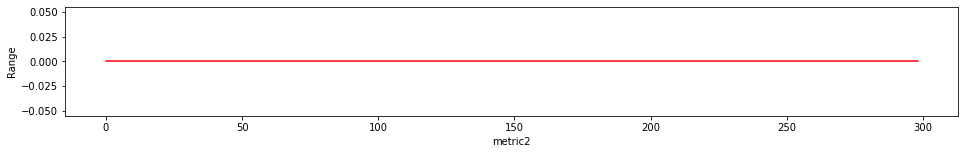

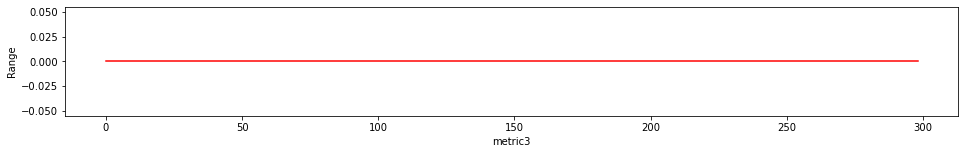

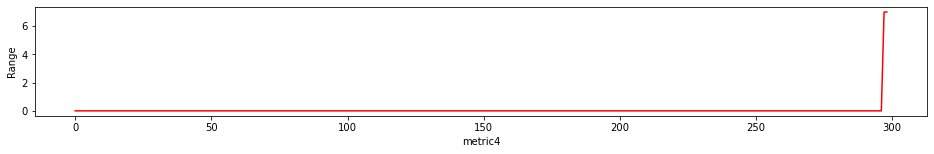

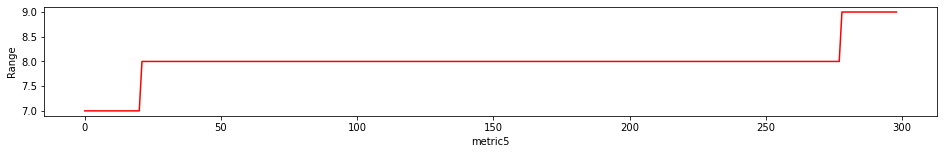

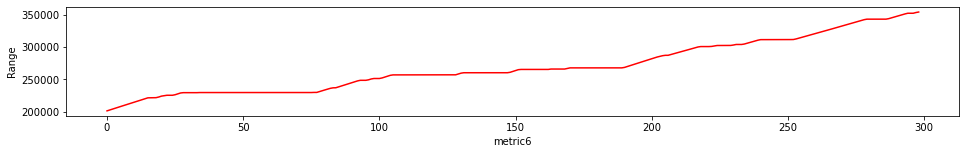

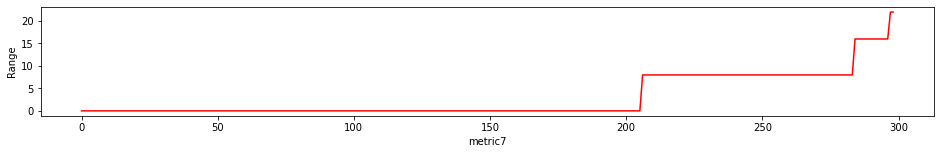

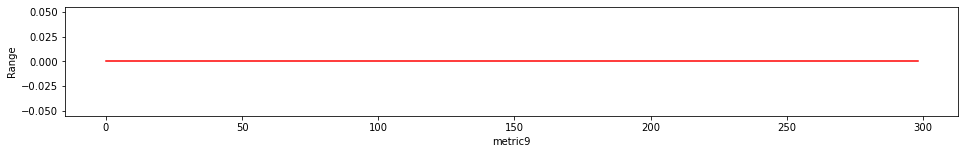

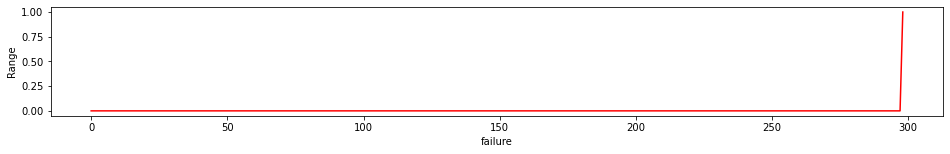

In [29]:
# display the metrics for one device
metrics=['metric2','metric3','metric4','metric5','metric6','metric7','metric9','failure']
for num in range(len(metrics)):
    plt.figure(figsize=(16,2))
    plt.plot(T0B1['timelapse'], T0B1[metrics[num]], color = 'r')
    plt.xlabel(metrics[num])
    plt.ylabel("Range")
    plt.show()

0    228
1     54
2     19
3      2
8      1
Name: failure, dtype: int64


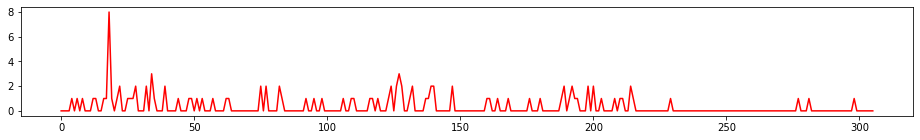

In [30]:
# on any given day, a certain number of devices failed. This is what we want to predict.

timefail=pd.DataFrame(df.groupby('timelapse')['failure'].sum())
print(timefail['failure'].value_counts()) 
plt.figure(figsize=(16,2))
plt.plot(timefail , color = 'r');

# Part 2. Modeling

## A. Cox regression analysis

The Cox proportional hazards model (1972) is widely used in multivariate survival statistics due to a relatively easy implementation and informative interpretation. It describes relationships between survival distribution and covariates. The Cox model makes an estimation of log-risk function λ(t|x) as a linear combination of its static covariates and baseline hazard.

In [31]:
# because metrics tend to vary over time, they're not fixed variables by device.
# device prefix does not vary, and thus serves as an independent variable.
coxdf = df[['device', 'failure', 'prefix', 'timelapse']]
coxdf = coxdf.groupby('device').max()
print(coxdf.shape)
coxdf.tail()

(1169, 3)


,failure,prefix,timelapse
device,,,
Z1F1VMZB,0,Z1F1,291
Z1F1VQFY,1,Z1F1,180
Z1F26YZB,0,Z1F2,83
Z1F282ZV,0,Z1F2,83
Z1F2PBHX,0,Z1F2,95


In [32]:
# one-hot encoding of device prefix
ohe=pd.get_dummies(coxdf['prefix'])
coxdf=pd.concat([coxdf, ohe],axis=1)
coxdf.head()

,failure,prefix,timelapse,S1F0,S1F1,W1F0,W1F1,Z1F0,Z1F1,Z1F2
device,,,,,,,,,,
S1F01085,0,S1F0,5,1,0,0,0,0,0,0
S1F013BB,0,S1F0,5,1,0,0,0,0,0,0
S1F0166B,0,S1F0,5,1,0,0,0,0,0,0
S1F01E6Y,0,S1F0,47,1,0,0,0,0,0,0
S1F01JE0,0,S1F0,5,1,0,0,0,0,0,0


Survival models in scikit-survival follow the same rules as estimators in scikit-learn, i.e., they have a fit method, which expects a data matrix and a structured array of survival times and binary event indicators.

In [33]:
# We drop one category for comparison purposes (intercept)
X=coxdf.drop(['prefix','failure','timelapse','S1F0'],axis=1)
X.columns

Index(['S1F1', 'W1F0', 'W1F1', 'Z1F0', 'Z1F1', 'Z1F2'], dtype='object')

In [34]:
# Convert time & failure into a structured array of booleans
coxdf['failure']=coxdf['failure'].astype('bool')
y=coxdf[['failure','timelapse']].to_records(index=False)
y[:5]

rec.array([(False,  5), (False,  5), (False,  5), (False, 47),
           (False,  5)],
          dtype=[('failure', '?'), ('timelapse', '<i8')])

In [35]:
# Split our data with a test size of 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [36]:
# Instantiate and fit the estimator
estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_train, y_train)

CoxPHSurvivalAnalysis()

In survival analysis, the hazard ratio (HR) is the ratio of the hazard rates corresponding to the conditions described by two levels of an explanatory variable. Each coefficient is a hazard ratio for that specific variable. 

- A positive sign increases the baseline hazard λ0(t) and denotes that this covariate affects a higher risk of experiencing the event of interest. In contrary, a negative sign means that the risk of the event is lower.
- For example, in a drug study, the treated population may die at twice the rate per unit time of the control population. The hazard ratio would be 2, indicating higher hazard of death from the treatment.

In [37]:
# extract coefficients
pd.Series(estimator.coef_, index=X_train.columns)

S1F1    -1.092256
W1F0     0.113487
W1F1    -0.227183
Z1F0    -0.352454
Z1F1     0.287970
Z1F2   -14.203354
dtype: float64

the `predict_survival_function` method returns a sequence of step functions, which we can plot. This shows the probability of a device not failing, for a given point in time (measured in days since device activation).

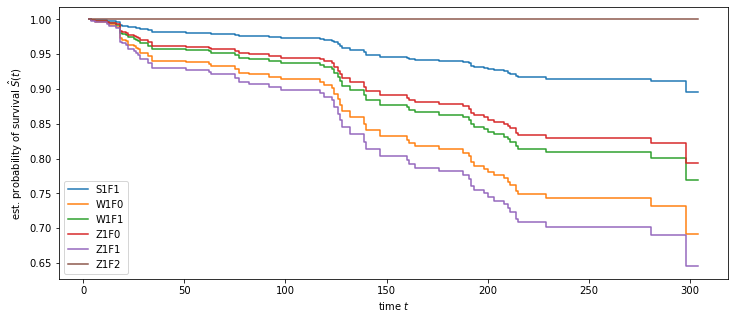

In [38]:
# create 7 new cases
x_new = pd.DataFrame.from_dict({
    1: [1,0,0,0,0,0],
    2: [0,1,0,0,0,0],
    3: [0,0,1,0,0,0],
    4: [0,0,0,1,0,0],
    5: [0,0,0,0,1,0],
    6: [0,0,0,0,0,1]
},
     columns=X_train.columns, orient='index')

# list the device categories
device_types=list(X_train.columns)
# display as curves
pred_surv = estimator.predict_survival_function(x_new)
time_points = np.arange(3, 305)
plt.figure(figsize=(12,5))
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label=device_types[i])
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best");

### Evaluation of Cox Regression

The most frequently used evaluation metric of survival models is the concordance index (c index, c statistic).  It is a measure of rank correlation between predicted risk scores f and observed time points y. Metrics like root mean squared error or correlation are unsuitable due to censoring.  The interpretation is identical to the traditional area under the ROC curve metric for binary classification: 
- a value of 0.5 denotes a random model, 
- a value of 1.0 denotes a perfect model, 
- a value of 0.0 denotes a perfectly wrong model.

In [39]:
# Measuring the Performance of the Survival Model
print(estimator.score(X_train,y_train))
cox_reg_score=estimator.score(X_test,y_test)
print(cox_reg_score)

0.5907687449563174
0.6056596091205212


Our model's c-index indicates that the model performs better than random chance, but is far from perfect. This is likely because we removed all of the attribute variables (metrics 2-9) from the analysis, which could have served as predictors. What this tells us is that lifespan, by itself, is not a strong predictor of when a device will fail (i.e., simply being old by itself is not necessarily a predictor of failure).  

A different approach (time series analysis) can take into account the device metrics which likely indicate upcoming failure.

## B. Multi-Task Logistic Regression (MTLR) 

When it comes to predicting the survival function for a specific unit, the Cox Proportional Hazard Model is usually the go-to model. However, it presents some important drawbacks:

- It relies on the proportional hazard assumption, which specifies that the ratio of the hazards for any two individuals is constant over time.
- The exact formula of the model that can handle ties isn’t computationally efficient, and is often rewritten using approximations, such as the Efron’s or Breslow’s approximations, in order to fit the model in a reasonable time.
- The fact that the time component of the hazard function remains unspecified makes the CoxPH model ill-suited for actual survival function predictions.  

The [Multi-Task Logistic Regression models](https://square.github.io/pysurvival/models/mtlr_theory.html) were therefore introduced to provide great alternatives.

The [Linear Multi-Task Logistic Regression (MTLR) model](https://square.github.io/pysurvival/models/linear_mtlr.html) is an alternative to the Cox’s proportional hazard model. It can be seen as a series of logistic regression models built on different time intervals so as to estimate the probability that the event of interest happened within each interval.

The model was introduced by Yu, Chun-Nam, et al. in 2011

### Train-test split 

In [43]:
# randomly select device ID numbers for train-test split
import random
device_ids=list(df['device'].unique())
test_size=int(len(device_ids)*.4)
print(test_size)
random.seed(10)
test_list = random.sample(device_ids, test_size)
print(test_list[:5])

467
['S1F0CVDS', 'W1F1CAKS', 'Z1F0L7PX', 'S1F04TS4', 'S1F115Z6']


In [44]:
# train-test split
data_test = df[df['device'].isin(test_list)]
data_train = df[~df['device'].isin(test_list)]
print(len(df))
print(len(data_train))
print(len(data_test))
assert len(data_train)+len(data_test)==len(df)

124446
71731
52715


In [42]:
# let's try with just a single predictor. Adding additional predictors produced inferior results.
features = [
#             'metric2', 
#             'metric3', 
#             'metric4', 
#             'metric5', 
            'metric6', 
#             'metric7',
#             'metric9',
#             'S1F0', 'S1F1', 'W1F0', 'W1F1', 'Z1F0', 'Z1F1', 'Z1F2'
           ]

In [43]:
# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train['timelapse'], data_test['timelapse']
E_train, E_test = data_train['failure'], data_test['failure']

In [44]:
# Let's now fit a Linear MTLR model to the training set. 
from pysurvival.models.multi_task import LinearMultiTaskModel

# Initializing the MTLR with a time axis split into 300 intervals
linear_mtlr = LinearMultiTaskModel(bins=300)

# Fitting the model
linear_mtlr.fit(X_train, T_train, E_train, 
                num_epochs = 500,
                init_method = 'orthogonal', 
                optimizer ='rmsprop',
                lr = 1e-6, 
                l2_reg = 3,  
                l2_smooth = 3
               )

% Completion: 100%|*********************************************|Loss: 27516.04


LinearMultiTaskModel

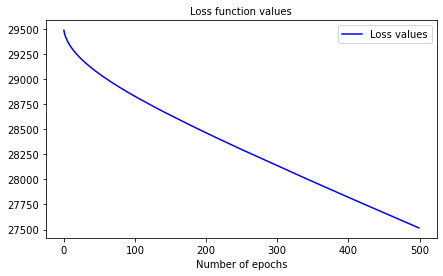

In [45]:
from pysurvival.utils.display import display_loss_values
display_loss_values(linear_mtlr, figure_size=(7, 4))

The [Concordance Index](https://square.github.io/pysurvival/metrics/c_index.html) or C-index is a generalization of the area under the ROC curve (AUC) that can take into account censored data. It represents the global assessment of the model discrimination power: this is the model’s ability to correctly provide a reliable ranking of the survival times based on the individual risk scores. In general, when the C-index is close to 1, the model has an almost perfect discriminatory power; but if it is close to 0.5, it has no ability to discriminate between low and high risk subjects.

In [46]:
from pysurvival.utils.metrics import concordance_index
linear_mtlr_c_index = concordance_index(linear_mtlr, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(linear_mtlr_c_index)) 

C-index: 0.55


## C. Feed-Forward Neural Network

The [Neural Multi-Task Logistic Regression model](https://square.github.io/pysurvival/models/neural_mtlr.html) (N-MTLR) was presented in Deep Neural Networks for Survival Analysis Based on a Multi-Task Framework allowing the use of Neural Networks within the original MTLR design. Although the MTLR model provides similar results as the CoxPH model without having to rely on the assumptions required by the latter, at its core, it is still powered by a linear transformation. Thus, in the presence of nonlinear elements in the data, it will stop yielding satisfactory performances. The Neural Multi-Task Logistic Regression (N-MTLR) which allows the use of Neural Networks within the original MTLR design, will help solve this issue.

In [45]:
# make a list of features
features = [
            'metric2', 
            'metric3', 
            'metric4', 
            'metric5', 
            'metric6', 
            'metric7',
            'metric9',
            'S1F0', 'S1F1', 'W1F0', 'W1F1', 'Z1F0', 'Z1F1', 'Z1F2'
           ]

In [46]:
# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train['timelapse'], data_test['timelapse']
E_train, E_test = data_train['failure'], data_test['failure']

The `structure` parameter provides the structure of the MLP built within the N-MTLR.
- `num_units` is the number of hidden units in this layer
- `activation` is the activation function that will be used. 

In [49]:
# Instantiate
from pysurvival.models.multi_task import NeuralMultiTaskModel
structure = [{'activation': 'Tanh', 'num_units': 60},  
             {'activation': 'ReLU', 'num_units': 60},
             {'activation': 'ReLU', 'num_units': 60},
               ]
neural_mtlm = NeuralMultiTaskModel(structure, bins=100, auto_scaler=True)

In [50]:
# Fitting the model
neural_mtlm.fit(X_train, T_train, E_train, 
                init_method = 'glorot_uniform', 
                optimizer ='adam',
                lr = 1e-3, 
                num_epochs = 1000, 
                dropout = 0.2, 
                l2_reg=1e-2,
                l2_smooth=1e-2, 
                batch_normalization=False, 
                bn_and_dropout=False,
                verbose=True, 
                extra_pct_time = 0.1, 
                is_min_time_zero=True)

% Completion: 100%|***********************************************|Loss: 523.63


NeuralMultiTaskModel( Layer(1): activation = Tanh, units = 60 ; 
                      Layer(2): activation = ReLU, units = 60 ; 
                      Layer(3): activation = ReLU, units = 60 )

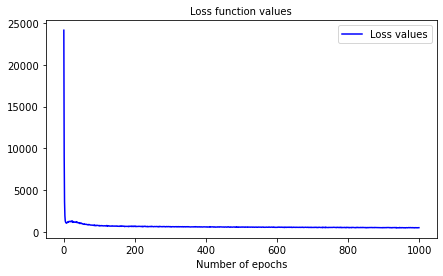

In [51]:
# loss function values
display_loss_values(neural_mtlm, figure_size=(7, 4))

In [52]:
# evaluation using concordance index
neural_c_index = concordance_index(neural_mtlm, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(neural_c_index)) 

C-index: 0.97


let's compare the time series of the actual and predicted number of device failures.

### Predicting on new data

In [78]:
# let's take a look at just one device.
T0B1.tail(2).T

,68967,68968
date,2015-10-25 00:00:00,2015-10-26 00:00:00
device,W1F0T0B1,W1F0T0B1
failure,0,1
metric2,0,0
metric3,0,0
metric4,7,7
metric5,9,9
metric6,354072,354861
metric7,22,22
metric9,0,0


In [66]:
# set up the components.
X_T0B1 = T0B1[list(X_test.columns)]
T_T0B1 = T0B1['timelapse']
E_T0B1 = T0B1['failure']

In [56]:
# make the predictions (note: their length is determined by the length of T0B1)
new_predictions = neural_mtlm.predict_survival(X_T0B1)
print(len(T0B1))
print(len(new_predictions))

299
299


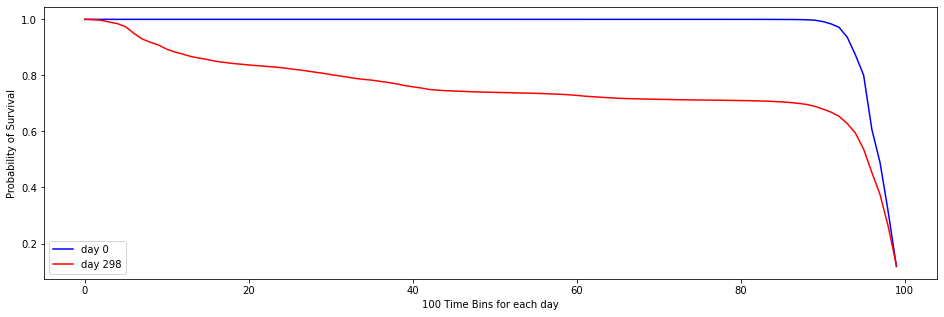

In [57]:
# predictions for day 0 and day 298:
plt.figure(figsize=(16,5))
plt.plot(pd.Series(new_predictions[0]), color = 'b',label='day 0')
plt.plot(pd.Series(new_predictions[298]), color = 'r',label='day 298')
plt.xlabel("100 Time Bins for each day")
plt.ylabel("Probability of Survival")
plt.legend(loc="lower left")
plt.show()

#### Hazard function.
Derived from the survival function the hazard function h(t) gives the conditional probability of the event occurring at time t, given that the subject did not experience the event prior to time t. 

In [58]:
# hazard
predicted_hazard = neural_mtlm.predict_hazard(X_T0B1)
print(len(predicted_hazard))
print(len(predicted_hazard[0]))

299
99


2.9998021536600508
2.606067879767517


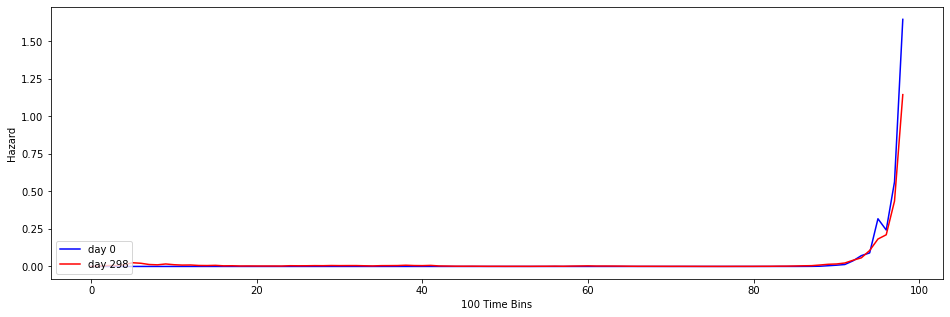

In [59]:
# hazard for day 0 and day 298:
print(predicted_hazard[0].sum())
print(predicted_hazard[298].sum())

plt.figure(figsize=(16,5))
plt.plot(pd.Series(predicted_hazard[0]), color = 'b',label='day 0')
plt.plot(pd.Series(predicted_hazard[298]), color = 'r',label='day 298')
plt.xlabel("100 Time Bins")
plt.ylabel("Hazard")
plt.legend(loc="lower left")
plt.show()

#### Risk function
However, the hazard function is rarely used in its original form. Most of the time, we subdivide the time axis in 
J parts and calculate the risk score of a sample x as derived from the hazard function.

In [60]:
# risk
predicted_risk = neural_mtlm.predict_risk(X_T0B1)
print(len(predicted_risk))

299


In [61]:
# risk for day 0 and day 298:
print(predicted_risk[0])
print(predicted_risk[298])

6.185246073022913
31.249855714646948


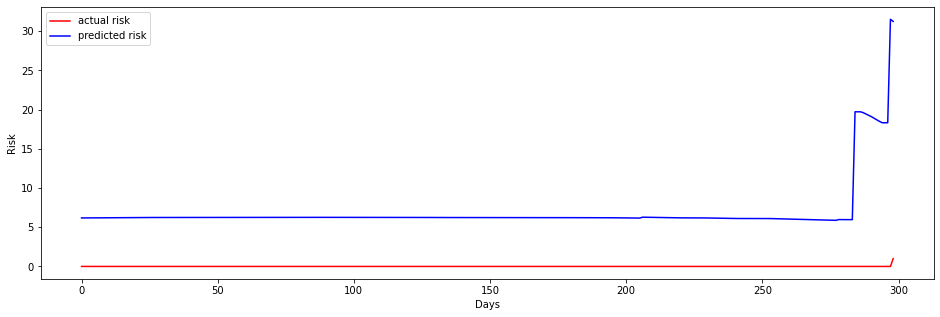

In [62]:
# actual vs. predicted risk 
plt.figure(figsize=(16,5))
plt.plot(T0B1['timelapse'], T0B1['failure'], color = 'r', label='actual risk')
plt.plot(T0B1['timelapse'], pd.Series(predicted_risk), color = 'b', label='predicted risk')
plt.xlabel("Days")
plt.ylabel("Risk")
plt.legend(loc="upper left")
plt.show()

## D. DeepSurv Neural Cox

The [NonLinear CoxPH model](https://square.github.io/pysurvival/models/nonlinear_coxph.html) was popularized by Katzman et al. in DeepSurv: Personalized Treatment Recommender System Using A Cox Proportional Hazards Deep Neural Network by allowing the use of Neural Networks within the original design and therefore introducing more modeling flexibility.



The `structure` parameter provides the structure of the MLP built within the N-MTLR.
- `num_units` is the number of hidden units in this layer
- `activation` is the activation function that will be used. 

In [47]:
# Instantiate
from pysurvival.models.semi_parametric import NonLinearCoxPHModel

structure = [ {'activation': 'ReLU', 'num_units': 128}, {'activation': 'Tanh', 'num_units': 128}, ]

neural_cox = NonLinearCoxPHModel(structure=structure)

In [48]:
# Fitting the model
neural_cox.fit(X_train, T_train, E_train, 
                init_method = 'glorot_uniform', 
                optimizer ='adam',
                lr = 1e-4, 
                num_epochs = 1000, 
                dropout = 0.2, 
                batch_normalization=False, 
                bn_and_dropout=False,
                verbose=True)

% Completion: 100%|***********************************************|Loss: 481.78


NonLinearCoxPHModel( Layer(1): activation = ReLU, num_units = 128 ; 
                     Layer(2): activation = Tanh, num_units = 128 )

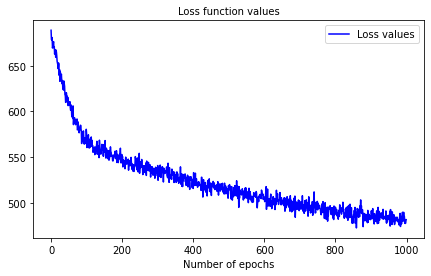

In [51]:
# loss function values
display_loss_values(neural_cox, figure_size=(7, 4))

### Evaluation

In [61]:
# this is why RMSE is not a useful metric:
predictions = neural_cox.predict_survival(X_test)
print(len(E_test))
print(len(predictions))
print(E_test[289])
print(len(predictions[0]))
print(predictions[0])

52715
52715
0
49
[0.99994921 0.99986667 0.99976764 0.99965034 0.99952973 0.99939253
 0.99833338 0.99817221 0.99800641 0.99767268 0.99750127 0.9973242
 0.99692945 0.99650275 0.99628599 0.99584051 0.99561003 0.99536529
 0.99511618 0.99485766 0.99459551 0.99432567 0.99366116 0.99326991
 0.99281461 0.99229171 0.99174684 0.9911813  0.99060577 0.98930737
 0.98860684 0.98781111 0.98691313 0.98506923 0.98319105 0.98217996
 0.98106128 0.97980032 0.97850125 0.97704938 0.97557759 0.97231554
 0.96894635 0.96717548 0.96516972 0.96301213 0.960763   0.95803642
 0.95254229]


In [95]:
# evaluation
neural_cox_c_index = concordance_index(neural_cox, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(neural_cox_c_index)) 

C-index: 0.96


### Predicting on new data

In [67]:
# make the predictions (note: their length is determined by the length of T0B1)
new_predictions = neural_cox.predict_survival(X_T0B1)
print(len(T0B1))
print(len(new_predictions))
print(len(new_predictions[0]))

299
299
49


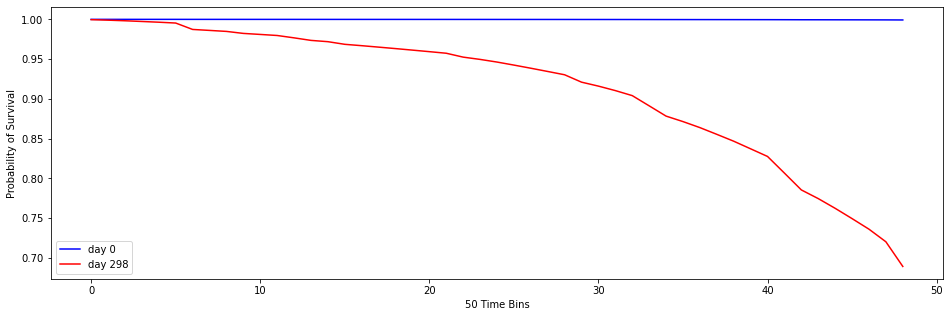

In [68]:
# predictions for day 0 and day 298:
plt.figure(figsize=(16,5))
plt.plot(pd.Series(new_predictions[0]), color = 'b',label='day 0')
plt.plot(pd.Series(new_predictions[298]), color = 'r',label='day 298')
plt.xlabel("50 Time Bins")
plt.ylabel("Probability of Survival")
plt.legend(loc="lower left")
plt.show()

In [98]:
# hazard
predicted_hazard = neural_cox.predict_hazard(X_T0B1)
print(len(predicted_hazard))
print(len(predicted_hazard[0]))

299
49


0.0005226801700391766
0.3588776690942417


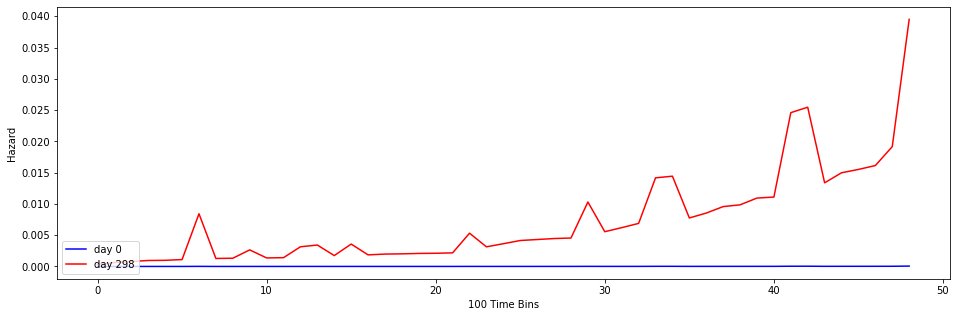

In [99]:
# hazard for day 0 and day 298:

print(predicted_hazard[0].sum())
print(predicted_hazard[298].sum())

plt.figure(figsize=(16,5))
plt.plot(pd.Series(predicted_hazard[0]), color = 'b',label='day 0')
plt.plot(pd.Series(predicted_hazard[298]), color = 'r',label='day 298')
plt.xlabel("100 Time Bins")
plt.ylabel("Hazard")
plt.legend(loc="lower left")
plt.show()

In [69]:
# risk
predicted_risk = neural_cox.predict_risk(X_T0B1)
print(len(predicted_risk))

299


In [70]:
# risk for day 0 and day 298 (odds ratio):
print(predicted_risk[0])
print(predicted_risk[298])

0.078686565
38.27524


In [73]:
# Probability = Odds / ( 1 + odds )
probabilities=[]
for odds_ratio in predicted_risk:
    prob=odds_ratio/(1+odds_ratio)
    probabilities.append(prob)
print(len(probabilities))

299


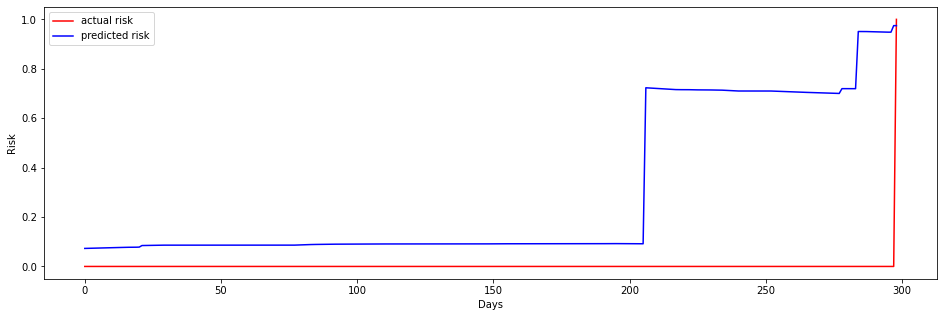

In [74]:
# actual vs. predicted risk 
plt.figure(figsize=(16,5))
plt.plot(T0B1['timelapse'], T0B1['failure'], color = 'r', label='actual risk')
plt.plot(T0B1['timelapse'], pd.Series(probabilities), color = 'b', label='predicted risk')
plt.xlabel("Days")
plt.ylabel("Risk")
plt.legend(loc="upper left")
plt.show()

In [79]:
# set a risk threshold & determine a specific day for maintenane, for this device.
threshold=.60
safe=[prob for prob in probabilities if prob<threshold]
cutoffdate=len(safe)
print(cutoffdate)

206


## Part 3: Conclusion: comparison of models

In [103]:
# compare all four models
comparison = pd.DataFrame([cox_reg_score, linear_mtlr_c_index, neural_c_index, neural_cox_c_index ], 
             index=['cox_reg_score', 'linear_mtlr_score', 'neural_mtlm_score', 'neural_cox_score'],
             columns=['score'])
comparison

,score
cox_reg_score,0.605660
linear_mtlr_score,0.553222
neural_mtlm_score,0.966610
neural_cox_score,0.962879


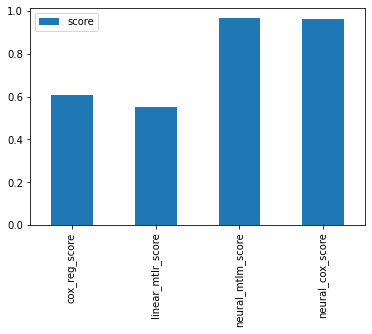

In [104]:
comparison.plot(kind='bar');

### References

* https://square.github.io/pysurvival/models/neural_mtlr.html
* https://humboldt-wi.github.io/blog/research/information_systems_1920/group2_survivalanalysis/
* https://scikit-survival.readthedocs.io
* https://www.kdnuggets.com/2020/07/guide-survival-analysis-python-part-3.html
* https://github.com/jaredleekatzman/DeepSurv